<a href="https://colab.research.google.com/github/orbenishay/Classification/blob/master/Toxic_comments_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Toxic comments classification**
![](https://techcrunch.com/wp-content/uploads/2013/06/hatespeech-tilt.jpg?w=200&crop=1)

Pre-processing:
* convert to lowercase
* decide if to replace \n by space or period
* remove words that have numbers inside them
* remove any other non letter charachter
* RE:

Questions:
* We may want to use a trained model instead of training on this limied dataset.
* Which word embedding methodology to use? BOW (Bag Of Word),Word2Vec,Doc2Vec,  FastText,TFIDF
* Strategy\plan how to clean the vocabulary
* Derive direct feaures from the text
* Classification of 6 categories
* Apply word vectors on comments
* EDA: correlation between the columns
* Kaggle collaborate on notebook

Direct features:
* contains question Mark
* contains exclamation mark (especially multiple - and count them)
* contains words with all capital
* begins with hi (or similar)
* begins with 'I'; begins with 'You'
* begins with a capital or small letter
* contains parenthesis
* conains curses from a glosary: fuck, shit, ass, looser, dick, bitch, suck, Nazi,stupid, bullshit, piss, cock, jew, die, cunt, rape, gay, cut, looser, nigger
*  contains negative words: bad, terrible, kill, block, stop, wrong, destroy, absurd, don't, mom, mother, fat
* conains A$$HOLE, NIGGA, FVCK, cra*p, fxxk
* abbreviations: OMG, LMAO, WTF, FFS

Remove:
* Multiple spaces
* Usernames: JacobBarnett52698
* email addresses
* '=', '-',
* IP addresses
* DateTime
* Comments that are less than 4 charachters
* Names (words that start with capital at middle of sentence)

Terms:
* tockens
* corpus: a collection of documents/sentences
* NLP: Neuro-linguistic programming
* NLTK: Natural Language Toolkit
* tokenize = splitting a comment into the component words


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
import re
import sys
import tensorflow as tf
from sklearn.manifold import TSNE # t-distributed Stochastic Neighbor Embedding; to visualize high-dimensional data. 
from sklearn.feature_extraction.text import TfidfVectorizer # Convert a collection of raw documents to a matrix of TF-IDF features.
import gensim
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec, KeyedVectors
from wordcloud import WordCloud, STOPWORDS
! pip install nltk
import nltk #natural language tool kit
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
!pip install replacer #replace with regex

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import files
    uploaded = files.upload()

Saving train1000.csv to train1000.csv


Get the data

In [5]:
traincomments=pd.read_csv('train1000.csv')
traincomments.head()
traincomments.info()
traincomments.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             999 non-null    object
 1   comment_text   999 non-null    object
 2   toxic          999 non-null    int64 
 3   severe_toxic   999 non-null    int64 
 4   obscene        999 non-null    int64 
 5   threat         999 non-null    int64 
 6   insult         999 non-null    int64 
 7   identity_hate  999 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 62.6+ KB


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
994,02b8c8ba3b2a1b35,I've removed it. It contributes NOTHING to the...,0,0,0,0,0,0
995,02b8e9f1f138d728,""" Hi, Writingrights, Welcome to Wikipedia! \n...",0,0,0,0,0,0
996,02b90e56ec25a4c1,It is common knowledge that Karaims (but not K...,0,0,0,0,0,0
997,02b91acc085c26f8,", 12 April 2006 (UTC)\nThen rewrite and expand...",0,0,0,0,0,0
998,02b94ce316048bc1,"""I was trying to inject some humour (as eviden...",0,0,0,0,0,0


Add columns

In [0]:
traincomments['number_categories']= traincomments.iloc[:, 2:8].sum(axis=1) # categories count
traincomments['exclamation_mark_count']=traincomments['comment_text'].str.count('!') # count '!'
def find_exclamation_mark_consecutive(x):
    n = 0
    matches = re.findall(r'[!]{2,}', x) 
    for m in matches:
        if  len(m)>n:
            n=len(m)
    return n
traincomments['exclamation_mark_consecutive']=traincomments['comment_text'].apply(lambda x: find_exclamation_mark_consecutive(str(x)))
traincomments['question_mark_count']=traincomments['comment_text'].str.count('\?') # count '?'
def find_question_mark_consecutive(x): 
    n = 0
    matches = re.findall(r'[?]{2,}', x) 
    for m in matches:
        if  len(m)>n:
            n=len(m)
    return n 
traincomments['question_mark_consecutive']=traincomments['comment_text'].apply(lambda x:find_question_mark_consecutive(str(x))) 
traincomments['comment_characters']=traincomments['comment_text'].str.len() #count characters
traincomments['comment_words']=traincomments['comment_text'].str.split().str.len() # count words
traincomments['comment_short']=traincomments['comment_text'].apply(lambda x: len(str(x))<=100) # number of characters less than 100
#Sentense count in each comment:
    #use '\n' to count the number of sentences in each comment #?,!,.; (list)
# traincomments['count_sentences']=traincomments.comment_text.apply(lambda x: len(re.findall("\n",str(x)))+1)
traincomments['count_sentences']=traincomments.comment_text.apply(lambda x: len(nltk.tokenize.sent_tokenize(str(x))))
traincomments['count_unique_word']=traincomments.comment_text.apply(lambda x: len(set(str(x).split()))) # count unique words
#count upper case words:
traincomments["count_words_upper"] = traincomments.comment_text.apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#count title case words:
traincomments["count_words_title"] = traincomments.comment_text.apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords:
eng_stopwords = set(stopwords.words("english"))
traincomments["count_stopwords"] =traincomments.comment_text.apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words:
traincomments["mean_word_len"] = traincomments.comment_text.apply(lambda x: np.mean([len(w) for w in str(x).split()]))
#if there is any word with all upper:
# traincomments['all_upper']=traincomments['comment_text'].str.split().apply(lambda x: np.any([True if w.isupper() else False for w in x]))
#the comment begins with greeting:
traincomments['begins_greeting'] = traincomments['comment_text'].apply(lambda x: True if re.match('^hey|hi|hello', str(x), re.IGNORECASE) else False)
#if begine with "I":
traincomments['begins_I'] = traincomments['comment_text'].apply(lambda x: True if re.match('^I ', str(x), re.IGNORECASE) else False)
#if begins with "You":
traincomments['begins_You'] = traincomments['comment_text'].apply(lambda x: True if re.match('^You', str(x), re.IGNORECASE) else False)
#if begins with capital:
traincomments['begins_capital'] = traincomments['comment_text'].apply(lambda x: True if re.match('^[A-Z].*', str(x)) else False)
# if contains_parenthesis:
traincomments['contains_parenthesis'] = traincomments['comment_text'].apply(lambda x: True if re.search('\(|\)', str(x)) else False)
#if contains curse:
traincomments['contains_curse'] = traincomments['comment_text'].apply(lambda x: True if re.search('fuck|shit |ass| looser | dick|bitch|suck|Nazi|stupid|bullshit| piss | cock|jew| die | cunt| rape | gay | nigger | pussy|wank|faggot|dumb| crap | slut ', str(x),re.IGNORECASE) else False)
# if contains curse with replacement:
traincomments['contains_curse_replacement'] = traincomments['comment_text'].apply(lambda x: True if re.search('A$$HOLE|NIGGA|FVCK|cra*p|fxxk|b*tch', str(x),re.IGNORECASE) else False)
#contains negative terms:
traincomments['contains_negative_terms'] = traincomments['comment_text'].apply(lambda x: True if re.search(' bad | terrible | kill | block | stop | wrong | destroy | absurd | don\'t | mom | mother | fat | cut | burn | ugly | kick | liar ', str(x),re.IGNORECASE) else False)
#contains abbreviations:
traincomments['contains_abbreviations'] = traincomments['comment_text'].apply(lambda x: True if re.search(' OMG | LMAO |WTF|FFS', str(x),re.IGNORECASE) else False)

# **Initial Cleanning & Tokenizing**

In [0]:
#does the same like belo, right?
words_with_numbers_pattern = re.compile(r'\w*[\d]+\w*') # letter\s (0 or more), digit (1 or more), letter\s (0 or more)
special_chars_pattern = re.compile(r'[,."!?:;=&*\\/()\'$^#]+')
def clean(s):
    s = re.sub(words_with_numbers_pattern, '', s).strip()  # get rid of numbers or words with numbers 
    s = re.sub(special_chars_pattern, '', s)  # remove special chars without removing words
    # ''.join([char.strip(',."!?:;=&*\\/()\'$^#') for char in s])  # remove these characters - this is so slow-- change to re
    return s

In [0]:
comment_list = traincomments[:159571]['comment_text'].values # gives a list of all comments
comment_list=[str(c).lower() for c in comment_list] # need to do with "map" before
sentences_list = [re.split('[.\n!?]',line) for line in comment_list] # gives a list of list (each list is a list of sentences corresponding to 1 comment)
sentences = [s for sentence in sentences_list for s in sentence] # gives a list of all sentences; we loose the comment context
sentences = [clean(s) for s in sentences if len(s) > 1]
sentences = [s.split() for s in sentences] # list of list; words within sentences
sentences = [words_list for words_list in sentences if len(words_list)>1] # remove lists with 1 word or less

# **Data Exploration:**

In [12]:
# traincomments.shape
traincomments.nunique()
# traincomments.info()
# traincomments.describe()
# print(traincomments.obscene.value_counts())
# print(traincomments.threat.value_counts())
# print(traincomments.insult.value_counts())
# print(traincomments.identity_hate.value_counts())
# print(traincomments.toxic.value_counts())
# print(traincomments.severe_toxic.value_counts())

id                              999
comment_text                    999
toxic                             2
severe_toxic                      2
obscene                           2
threat                            2
insult                            2
identity_hate                     2
number_categories                 6
exclamation_mark_count           12
exclamation_mark_consecutive      6
question_mark_count              10
question_mark_consecutive         5
comment_characters              559
comment_words                   219
comment_short                     2
count_sentences                  34
count_unique_word               170
count_words_upper                36
count_words_title                62
count_stopwords                 142
mean_word_len                   753
begins_greeting                   2
begins_I                          2
begins_You                        2
begins_capital                    2
contains_parenthesis              2
contains_curse              

The data does not contain missing values

# **Preliminary EDA**

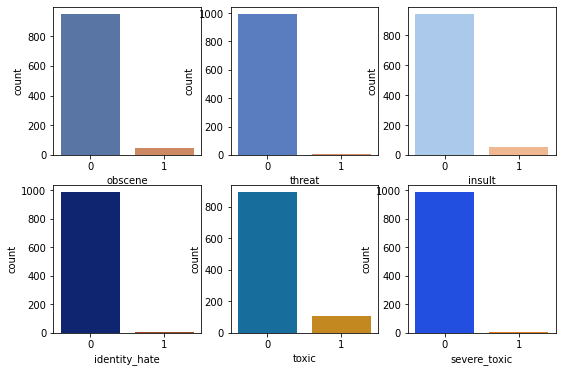

In [11]:
fig, plots = plt.subplots(2,3,figsize=(9,6))
plot1, plot2, plot3, plot4, plot5, plot6 = plots.flatten()
sns.countplot(traincomments['obscene'], palette= 'deep', ax = plot1)
sns.countplot(traincomments['threat'], palette= 'muted', ax = plot2)
sns.countplot(traincomments['insult'], palette = 'pastel', ax = plot3)
sns.countplot(traincomments['identity_hate'], palette = 'dark', ax = plot4)
sns.countplot(traincomments['toxic'], palette= 'colorblind', ax = plot5)
sns.countplot(traincomments['severe_toxic'], palette= 'bright', ax = plot6)

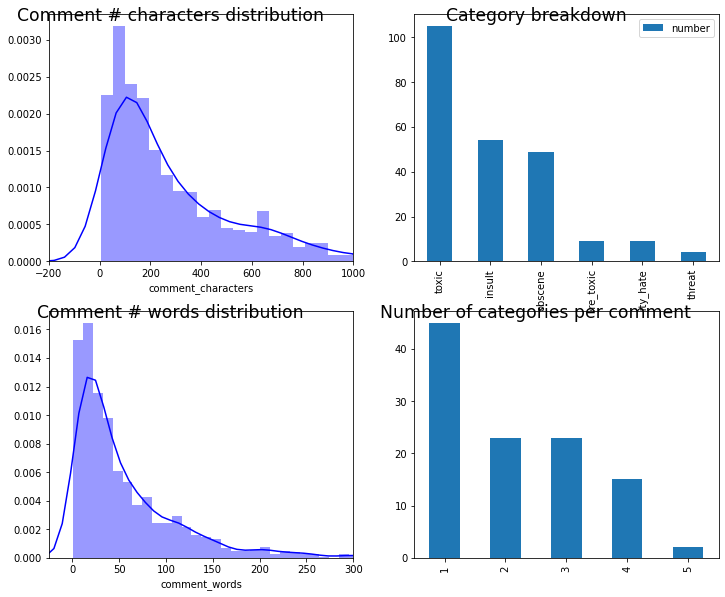

In [13]:
sums=traincomments[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].sum(axis=0)
sums_df=pd.DataFrame(data=sums, columns=['number'])
fig = plt.figure()
fig.set_size_inches(12,10)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.set_title("Comment # characters distribution", x=0.4, y=0.95, ha='center', fontsize='xx-large');
ax2.set_title("Category breakdown", x=0.4, y=0.95, ha='center', fontsize='xx-large');
ax3.set_title("Comment # words distribution", x=0.4, y=0.95, ha='center', fontsize='xx-large');
ax4.set_title("Number of categories per comment", x=0.4, y=0.95, ha='center', fontsize='xx-large');
sns.distplot(traincomments.comment_characters, bins=100, kde=True, color='blue', ax=ax1);
ax1.set_xlim(-200,1000)
sums_df.sort_values(by='number',ascending=False).plot.bar(ax=ax2);
sns.distplot(traincomments.comment_words, bins=100, kde=True, color='blue', ax=ax3);
ax3.set_xlim(-25,300)
traincomments[traincomments['number_categories']>0]['number_categories'].value_counts().sort_index(ascending=True).plot.bar(ax=ax4);
plt.show()


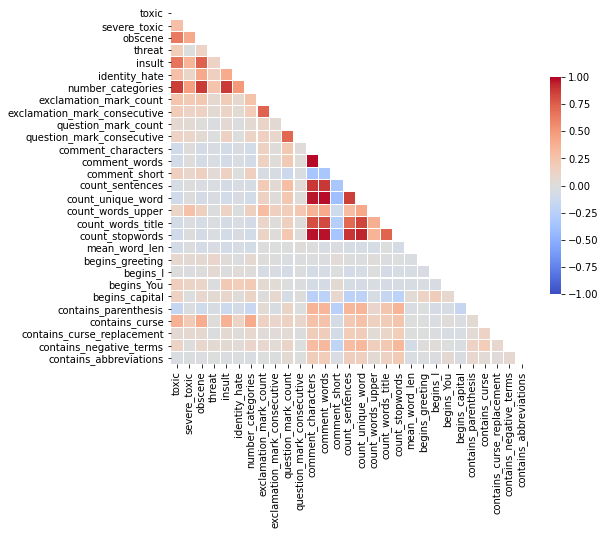

In [63]:
# corr_df = traincomments[traincomments['number_categories']>0]
corr_df = traincomments
corr=corr_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(8,8))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=False, mask=mask, vmin=-1,vmax=1, center=0,
            square=True, linewidths=.1, cbar_kws={"shrink": .5}, annot_kws={"size": 7},cmap='coolwarm'); #

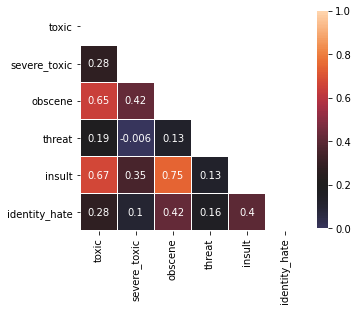

In [66]:
corr_df =traincomments[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]
corr=corr_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(5,5))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True, mask=mask, vmax=1,vmin=0, center=0.2,
            square=True, linewidths=.2, cbar_kws={"shrink": .8}, annot_kws={"size": 10});

In [75]:
traincomments.groupby('contains_curse').agg({'number_categories':'mean'}).head()

# comment_short                     2
# begins_greeting                   2
# begins_I                          2
# begins_You                        2
# begins_capital                    2
# contains_parenthesis              2
# contains_curse                    2
# contains_curse_replacement        2
# contains_negative_terms           2
# contains_abbreviations            2

,number_categories
contains_curse,
False,0.081907
True,0.900552


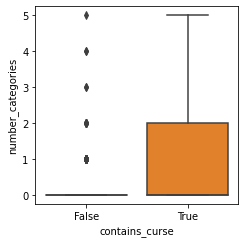

In [74]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
# ax2 = fig.add_subplot(222)
fig.set_size_inches(8,8)
sns.boxplot(x='contains_curse', y='number_categories', hue=None, data=traincomments, order=None, hue_order=None,ax=ax1);
# sns.violinplot(x='bathrooms', y='price', data=bnb,ax=ax2);
# ax1.set_title("Price distribution by bedrooms - BoxPlot", x=0.4, y=0.95, ha='center', fontsize='xx-large');
# ax2.set_title("Price distribution by bedrooms - Violin Plot", x=0.4, y=0.95, ha='center', fontsize='xx-large');

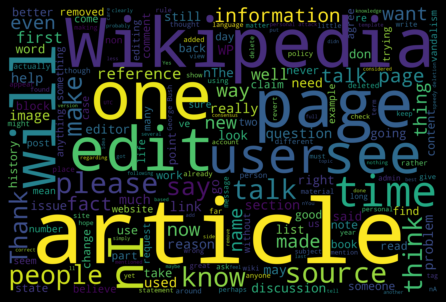

In [22]:
text = traincomments['comment_text'].values

wordcloud = WordCloud(width = 3000,height = 2000,background_color = 'black',stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(figsize = (6, 6), facecolor = 'k',edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# **Word2Vec**

In [0]:
from gensim.models import Word2Vec
model = Word2Vec(sentences, size=100, window=5, min_count=3, workers=4)
vectors = model.wv
vectors.most_similar('kill') #example

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('shoot', 0.7969218492507935),
 ('wear', 0.7220192551612854),
 ('marry', 0.6954490542411804),
 ('drink', 0.6821300983428955),
 ('punish', 0.6682694554328918),
 ('kick', 0.6673578023910522),
 ('burn', 0.6649954319000244),
 ('sue', 0.6590555310249329),
 ('swear', 0.6510705351829529),
 ('eat', 0.6476502418518066)]

In [0]:
len(model.wv.vocab) #how many words in the vocabulary

62521

In [0]:
# build a list of the terms and terms count
ordered_vocab = [(term, voc.index, voc.count) for term, voc in model.wv.vocab.items()]

# sort by the term counts, so the most common terms appear first
ordered_vocab = sorted(ordered_vocab, key=lambda k: -k[2])

# unzip the terms, integer indices, and counts into separate lists
ordered_terms, term_indices, term_counts = zip(*ordered_vocab)
# print(ordered_terms)
# create a DataFrame with the food2vec vectors as data,
# and the terms as row labels
word_vectors = pd.DataFrame(model.wv.syn0norm[term_indices, :], index=ordered_terms)

word_vectors

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.wv.vectors_norm instead).
  # This is added back by InteractiveShellApp.init_path()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
the,0.127473,0.030437,0.000826,0.219047,0.014856,0.116636,-0.017844,-0.034483,0.009757,0.004311,0.058232,0.088888,0.132192,-0.149509,0.091238,0.223494,-0.031253,0.070459,-0.223600,-0.073280,0.128157,0.110343,0.020246,-0.074697,-0.129671,0.100515,-0.025389,0.072011,-0.099580,-0.018779,0.119204,0.094322,0.110030,0.074659,-0.124124,0.019045,0.030821,0.054409,-0.130690,0.027933,...,0.061038,0.035901,0.036263,0.053671,-0.026003,-0.218129,-0.021017,0.054819,-0.061392,0.055286,0.024428,0.048963,-0.066372,0.102796,0.219435,-0.150483,0.089745,-0.190108,0.122606,-0.072162,0.091362,-0.092704,0.020196,-0.034112,0.084462,0.011967,0.066335,-0.116898,-0.118317,0.093807,-0.035885,0.049112,-0.118025,-0.068711,0.015349,-0.007955,-0.082205,0.072710,-0.033340,0.067162
to,0.207968,-0.085588,0.101124,0.101411,0.166811,0.208800,0.124947,0.015048,-0.088157,-0.075834,0.029074,-0.021348,-0.016980,0.015682,-0.101924,0.107196,-0.064995,-0.073064,-0.085404,-0.092638,-0.062036,-0.034957,0.038508,-0.000507,0.064712,0.070913,0.126390,0.020026,-0.108027,-0.015667,-0.061729,0.062807,0.093385,0.103441,-0.039404,-0.010520,-0.152586,-0.122637,-0.182926,0.096424,...,-0.128910,0.138662,-0.109931,0.121142,-0.155737,-0.230895,0.002324,0.015232,0.022033,-0.002349,0.092233,0.036295,-0.163317,-0.076949,0.092408,0.002762,0.096337,-0.235796,0.003825,-0.140222,-0.090101,-0.127978,-0.127307,-0.065015,-0.072409,0.190323,0.090482,-0.121963,-0.110431,0.049603,-0.015743,-0.082877,-0.056328,0.017650,-0.154495,-0.060612,-0.142919,0.078630,-0.007934,-0.077762
of,0.190453,0.083136,-0.070625,-0.008129,0.062710,0.054248,-0.073975,-0.052942,0.019378,0.087750,0.037317,0.048504,0.107806,-0.079969,0.020388,0.137581,0.087208,-0.172970,-0.195134,-0.018994,-0.011102,0.126501,0.122571,0.011637,-0.034565,0.047855,0.139951,0.231765,0.049061,-0.095476,-0.029903,0.074032,0.096026,0.040134,0.084246,0.037430,0.090462,0.022176,0.050532,-0.050732,...,-0.102442,0.024537,0.058729,0.067983,0.018898,-0.168707,-0.048366,0.057288,-0.094584,-0.122611,0.060047,0.181335,-0.194220,-0.086755,0.147594,-0.060271,0.049088,0.018190,-0.061508,-0.139897,0.030670,-0.030316,0.093743,0.105762,0.085057,0.118507,-0.089106,-0.208018,0.093303,-0.031162,-0.196351,0.151644,0.041437,0.023761,0.007977,0.021037,0.000475,0.153124,0.014418,0.053465
and,0.329884,-0.109861,0.112617,0.152822,0.279767,0.092418,-0.058350,-0.061329,-0.021584,-0.013968,-0.089887,0.020813,0.146503,-0.030600,-0.082578,0.069231,0.014702,-0.152937,-0.203760,-0.077507,0.068362,0.103846,-0.137043,-0.075611,0.166935,-0.003391,0.025518,-0.111016,-0.021620,-0.059980,-0.023037,-0.023364,0.116690,0.036363,0.065576,0.077705,-0.087137,-0.009179,-0.131749,0.005235,...,0.017476,0.048038,0.108471,0.147424,0.003388,-0.125442,-0.017800,0.005158,-0.145177,-0.025105,-0.037517,-0.039908,-0.055027,-0.103130,0.052045,0.002501,0.076965,-0.253984,-0.112997,0.085938,-0.007815,-0.013712,0.010702,-0.029776,0.086110,0.130617,0.057575,-0.176544,0.047512,0.003241,-0.020715,0.114878,0.004007,-0.098165,-0.036641,-0.035452,-0.054749,-0.125954,-0.004930,0.040182
a,0.164115,0.081074,0.032965,-0.024742,0.021632,0.178145,-0.115937,0.132147,-0.107699,0.091230,0.021956,-0.037506,0.110332,0.014583,0.058191,0.140460,0.059742,-0.035727,-0.132609,0.032398,0.074843,0.038808,-0.103751,-0.161904,-0.062394,0.061695,-0.061289,0.058876,0.033477,-0.016641,0.229823,0.071749,-0.033366,0.115573,0.047995,-0.038296,-0.199058,0.130952,-0.239587,0.065014,...,-0.119738,0.082787,-0.063447,0.004962,0.026664,-0.160899,0.052283,-0.002622,-0.032082,0.029286,0.060651,0.146347,-0.061827,0.132055,0.118741,-0.034479,0.198615,0.069115,0.100215,-0.045572,0.010128,-0.115046,0.065709,-0.089253,-0.042654,-0.013332,0.027446,-0.199592,-0.028681,0.068876,0.055171,-0.044155,-0.063720,-0.031051,-0.1

In [0]:
def get_related_terms(token, topn=10):
    """
    look up the topn most similar terms to token
    and print them as a formatted list
    """

    for word, similarity in model.most_similar(positive=[token], topn=topn):
        print (word, round(similarity, 3))

In [0]:
#TSNE
how_many_to_use = 700
X = word_vectors[:how_many_to_use].to_numpy() # will use top most frequent
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
df = pd.DataFrame(X_tsne, index=word_vectors[:how_many_to_use].index.tolist(), columns=['x', 'y'])
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'])
for word, pos in df.iterrows():
    ax.annotate(word, pos)


# code to add vector per comment to training df
# need to clean comment_list before this
wvc=word_vectors.columns.tolist()
cols=traincomments.columns.tolist()
cols.extend(wvc)

traincomments=traincomments.reindex(columns=cols)
traincomments.head()
print(traincomments.columns.tolist())

for i, comment in enumerate(comment_list):
    org_words = clean(comment).split()
    words = [w for w in org_words if w in word_vectors.index]  #remove words not in model
    comment_vector=word_vectors.loc[words].mean(axis=0)   # average the word vectors for the comment (cum then normalize for word nmber)
    traincomments.loc[i, wvc]=comment_vector  # add the features to the df

traincomments.head()



['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'number_categories', 'exclamation_mark_count', 'exclamation_mark_consecutive', 'question_mark_count', 'question_mark_consecutive', 'comment_characters', 'comment_words', 'comment_short', 'count_sentences', 'count_unique_word', 'count_words_upper', 'count_words_title', 'count_stopwords', 'mean_word_len', 'all_upper', 'begins_greeting', 'begins_I', 'begins_You', 'begins_capital', 'contains_parenthesis', 'contains_curse', 'contains_curse_replacement', 'contains_negative_terms', 'contains_abbreviations', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


# **TFIDF**

process: 
1. stopword scleanning
2. stemming (go, goes, going = go)/lemmatizing (he,she,it= do)
3. clean "junk"
4. vectorizer (take the corpus and convert each doc/sentence into a sparse matrix of TFIDF)
5. LSA (dimentionality reduction)

###**Cleanning** **preprocessing**

In [0]:
replacement_patterns = [
 (r'won\'t', 'will not'),
 (r'can\'t', 'cannot'),
 (r'i\'m', 'i am'),
 (r'ain\'t', 'is not'),
 (r'(\w+)\'ll', '\g<1> will'),
 (r'(\w+)n\'t', '\g<1> not'),
 (r'(\w+)\'ve', '\g<1> have'),
 (r'(\w+)\'s', '\g<1> is'),
 (r'(\w+)\'re', '\g<1> are'),
 (r'(\w+)\'d', '\g<1> would'),
 (r'[-()\"#/@;:<>{}-=~|.?,]',''),
]

def strip_symbols(text):
    return ' '.join(re.compile(r'\W+', re.UNICODE).split(text))

class RegexpReplacer(object):
    def __init__(self, patterns=replacement_patterns):
        self.patterns = [(re.compile(regex), repl) for (regex, repl) in 
                     patterns]
    def replace(self, text):
      s = text
      for (pattern, repl) in self.patterns:
         s = re.sub(pattern, repl, s)
      return s

from nltk.stem import WordNetLemmatizer
lemma = []
wnl = WordNetLemmatizer()
for doc in low:
    tokens = [wnl.lemmatize(w) for w in doc]
    lemma.append(tokens)

# Removing Stopwords
filter_words = []
Stopwords = set(stopwords.words('english'))

#----???
#ab = spell('nd')
for sent in lemma:
    tokens = [w for w in sent if w not in Stopwords]
    filter_words.append(tokens)

space = ' ' 
sentences = []
for sentence in filter_words:
    sentences.append(space.join(sentence))
    

#FreqDist() function in nltk that counts word frequency
tokens = [t for t in traincomments.comment_text]
print(tokens)

sr= stopwords.words('english')
clean_tokens = tokens[:]
for token in tokens:
    if token in stopwords.words('english'):
        clean_tokens.remove(token)
        
freq = nltk.FreqDist(clean_tokens)
for key,val in freq.items():
    print(str(key) + ':' + str(val))
freq.plot(20, cumulative=False)

replacer = RegexpReplacer()
traincomments.comment_text = traincomments.comment_text.apply(lambda x:replacer.replace(x))
traincomments.comment_text = traincomments.comment_text.apply(lambda x:strip_symbols(x))

In [0]:
train.comment_text.head() #display the clean text

In [0]:
v = TfidfVectorizer()

X_train = v.fit_transform(train['comment_text'])
# X_test = v.transform(test['comment_text'])

for label in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    y = train[label]
    model = LogisticRegression()
    model.fit(X_train, y)
    test[label] = model.predict_proba(X_test)[:, 1]
    
test.drop('comment_text', axis=1, inplace=True)
test.to_csv('simplest.csv', index=False)

train = pd.read_csv(r'../input/train-data/train.csv')
tf = TfidfVectorizer(smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word')
X_train_fitted = tf.fit(X_train)
X_train_transformed = X_train_fitted.transform(X_train)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
myvocabulary = ['life', 'learning']
corpus = traincomments
tfidf = TfidfVectorizer(vocabulary = myvocabulary, ngram_range = (1,3))
tfs = tfidf.fit_transform(corpus.values())

TypeError: ignored